# Evaluation of Random Forest and Statisticsl Index Results

## Package Import, Working Directory and Functions

In [14]:
# import packages
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import seaborn as sns
from sklearn.metrics import average_precision_score, confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve


In [ ]:
# TODO: set working directory
work_dir = "/local/path/to/GEO403_landslide_susceptibility_analysis"
os.chdir(work_dir)

In [16]:
def load_raster(file_path, target_nodata=-9999):
    """
    Load raster data and replace NoData values.
    Args:
        file_path (str): Path to the raster file
        target_nodata (int/float): Value to replace NoData pixels with
    Returns:
        data (np.array): Raster data
        transform (Affine): Transformation matrix
        crs (CRS): Coordinate Reference System
        metadata (dict): Original metadata for possible export
    """ 
    with rasterio.open(file_path) as src:
        data = src.read(1)
        transform = src.transform
        crs = src.crs
        metadata = src.meta.copy()
        nodata = src.nodatavals[0]

        # convert to float32 if target_nodata is negative
        if target_nodata < 0:
            data = data.astype(np.float32)

        # replace nodata values
        if nodata is not None:
            data[data == nodata] = target_nodata

        return data, transform, crs, metadata


def plot_confusion_matrix(cm, title, ax):
    """Plot confusion matrix.
    Args:
        cm (np.array): Confusion matrix to plot
        title (str): Title of confusion matrix
        ax (np.array): Matplotlib axis to plot
    """
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)
    ax.xaxis.set_ticklabels(["No Landslide", "Landslide"])
    ax.yaxis.set_ticklabels(["No Landslide", "Landslide"])

## Load Susceptibility Predictions

In [17]:
# set raster file paths
raster_files = {
    "si": "created/predictions/SI_landslide_susceptibility_map.tif",
    "rf": "created/predictions/RF_landslide_susceptibility_map_viewshed.tif",
    "landslides": "created/aligned_rasters/landslides.tif",
    "view": "created/aligned_rasters/view_mask.tif",
}

# load raster data and save metadata
rasters = {}
transforms = {}
crs_dict = {}
metadata_dict = {}

# load rasters and store in dict
for key, file_path in raster_files.items():
    rasters[key], transforms[key], crs_dict[key], metadata_dict[key] = load_raster(file_path)
    print(f"Loaded raster {key}, Shape: {rasters[key].shape}")

Loaded raster si, Shape: (4838, 5486)
Loaded raster rf, Shape: (4838, 5486)
Loaded raster landslides, Shape: (4838, 5486)
Loaded raster view, Shape: (4838, 5486)


## Evaluate Susceptibility Precitions

### Prepare and Explore Data

In [18]:
# convert landslides to binary (1 = landslide, 0 = no landslide)
landslides = np.where(rasters["landslides"] == 1, 1, 0).astype(np.float32)

# apply view_mask to ensure only valid areas are used
valid_mask = ~np.isnan(rasters["view"])

# mask everything outside the view area
landslides[~valid_mask] = np.nan
rf = rasters["rf"].copy()
si = rasters["si"].copy()
rf[~valid_mask] = np.nan
si[~valid_mask] = np.nan

# normalize SI to [0, 1] range before evaluation
si_min, si_max = np.nanmin(si), np.nanmax(si)
si = (si - si_min) / (si_max - si_min)

# flatten arrays and remove nan values
mask_valid = ~np.isnan(landslides) & ~np.isnan(rf) & ~np.isnan(si)
y_true_eval = landslides[mask_valid].ravel()
y_pred_prob_rf_eval = rf[mask_valid].ravel()
y_pred_prob_si_eval = si[mask_valid].ravel()

print(f"Prepared data: {len(y_true_eval)} valid pixels")


Prepared data: 1595913 valid pixels


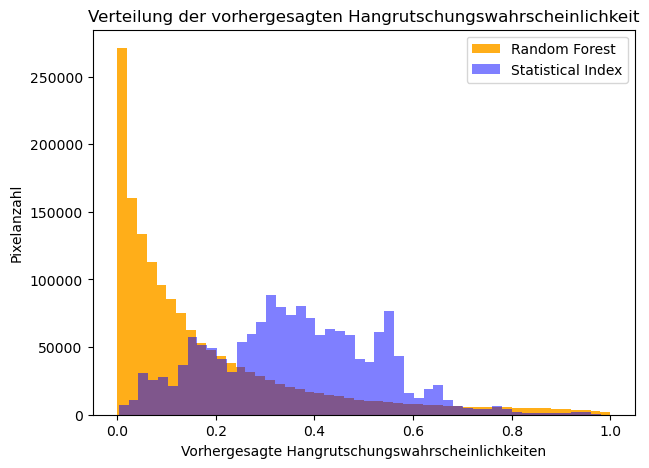

In [19]:
# plot histogram of random forest predictions and SI predictions
plt.figure(figsize=(7, 5))
plt.hist(y_pred_prob_rf_eval, bins=50, alpha=0.9, color="orange", label="Random Forest")
plt.hist(y_pred_prob_si_eval, bins=50, alpha=0.5, color="blue", label="Statistical Index")
plt.xlabel("Vorhergesagte Hangrutschungswahrscheinlichkeiten")
plt.ylabel("Pixelanzahl")
plt.title("Verteilung der vorhergesagten Hangrutschungswahrscheinlichkeit")
plt.legend()
plt.show()

### ROC-AUC and PR-AUC score

In [20]:
# compute ROC-AUC and PR-AUC
auc_rf = roc_auc_score(y_true_eval, y_pred_prob_rf_eval)
auc_si = roc_auc_score(y_true_eval, y_pred_prob_si_eval)
pr_auc_rf = average_precision_score(y_true_eval, y_pred_prob_rf_eval)
pr_auc_si = average_precision_score(y_true_eval, y_pred_prob_si_eval)

print(f"ROC-AUC RF: {auc_rf:.4f}, PR-AUC RF: {pr_auc_rf:.3f}")
print(f"ROC-AUC SI: {auc_si:.4f}, PR-AUC SI: {pr_auc_si:.3f}")


ROC-AUC RF: 0.9812, PR-AUC RF: 0.128
ROC-AUC SI: 0.8894, PR-AUC SI: 0.047


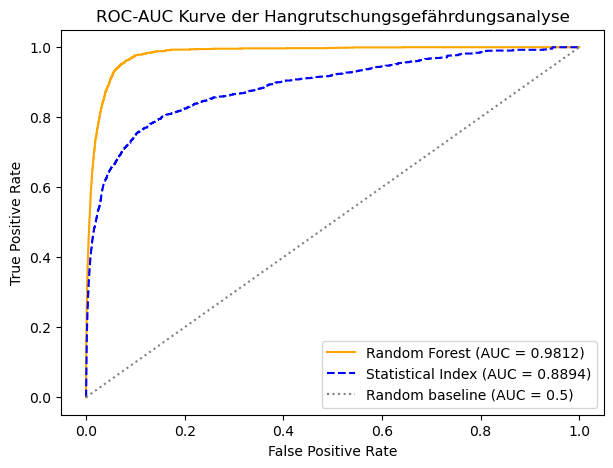

In [21]:
# compute ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_true_eval, y_pred_prob_rf_eval)
fpr_si, tpr_si, _ = roc_curve(y_true_eval, y_pred_prob_si_eval)

# plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.4f})", color="orange")
plt.plot(fpr_si, tpr_si, label=f"Statistical Index (AUC = {auc_si:.4f})", linestyle="dashed", color="blue")
plt.plot([0, 1], [0, 1], label="Random baseline (AUC = 0.5)", linestyle="dotted", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Kurve der Hangrutschungsgefährdungsanalyse")
plt.legend()
plt.show()


### Investigate Thresholds based on TSS, Precision and Recall


Threshold 0.50 (RF Model)
  Precision: 0.0122, Recall: 0.9702, TSS: 0.8775

Threshold 0.50 (SI Model)
  Precision: 0.0045, Recall: 0.8336, TSS: 0.6175


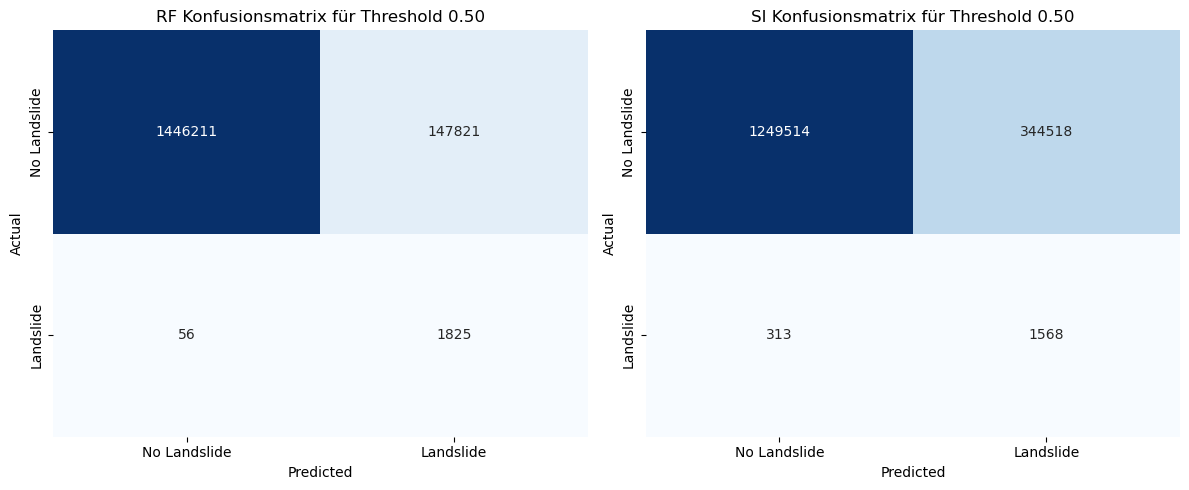


Threshold 0.70 (RF Model)
  Precision: 0.0240, Recall: 0.8820, TSS: 0.8396

Threshold 0.70 (SI Model)
  Precision: 0.0267, Recall: 0.5199, TSS: 0.4975


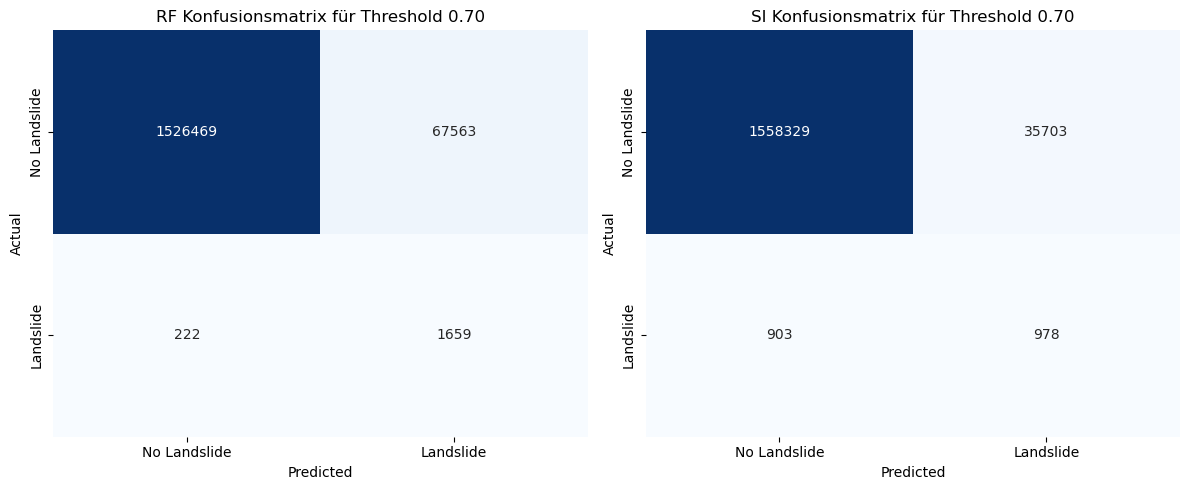


Threshold 0.80 (RF Model)
  Precision: 0.0359, Recall: 0.7804, TSS: 0.7557

Threshold 0.80 (SI Model)
  Precision: 0.0556, Recall: 0.3716, TSS: 0.3642


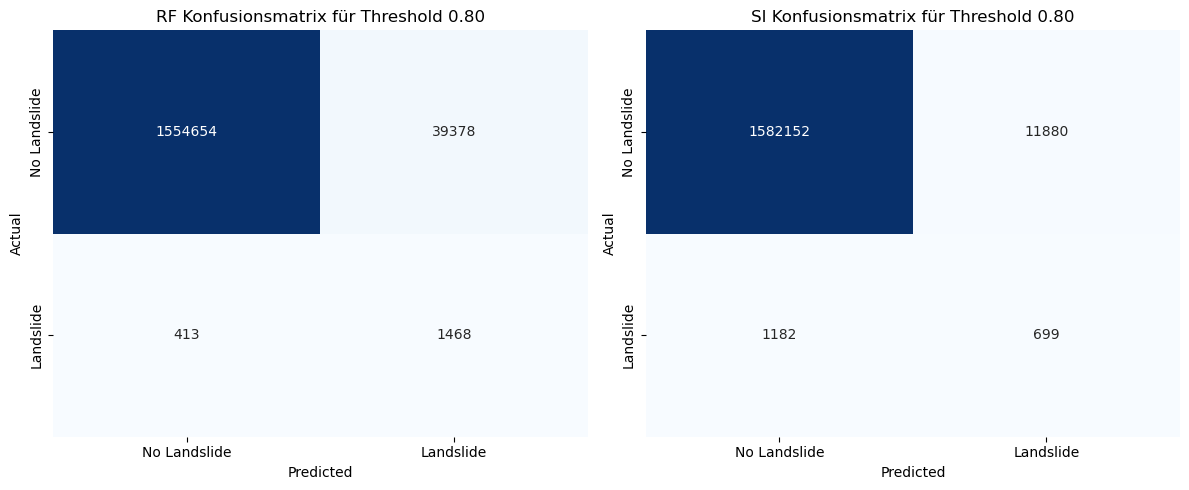


Threshold 0.99 (RF Model)
  Precision: 0.2673, Recall: 0.1334, TSS: 0.1330

Threshold 0.99 (SI Model)
  Precision: 0.0000, Recall: 0.0000, TSS: -0.0000


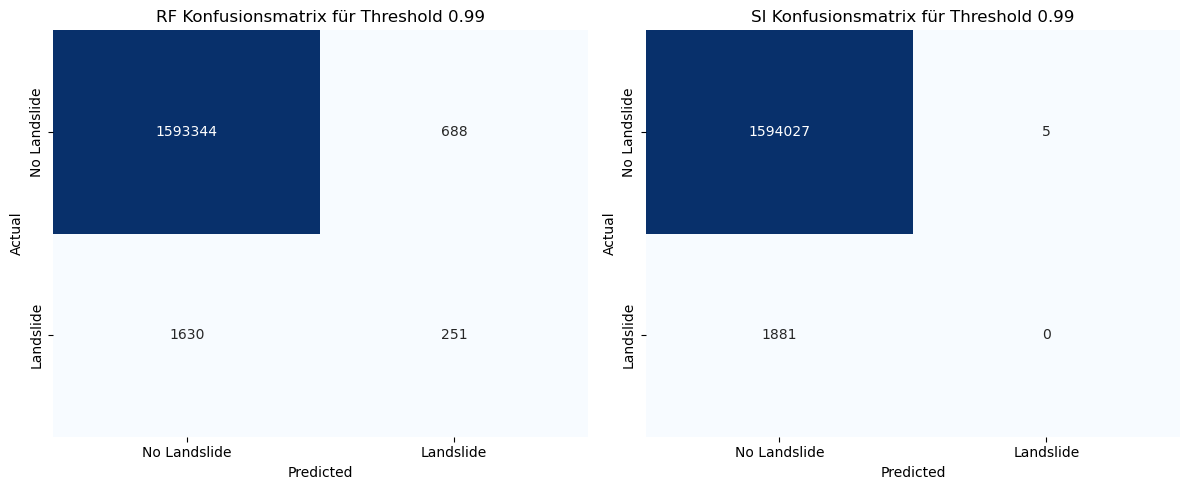

In [22]:
# define thresholds to evaluate
thresholds = [0.5, 0.7, 0.8, 0.99]

# Iiterate through thresholds and plot confusion matrices
for t in thresholds:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # One row, two columns

    # RF model evaluation
    y_pred_binary_rf = (y_pred_prob_rf_eval >= t).astype(int)
    cm_rf = confusion_matrix(y_true_eval, y_pred_binary_rf)
    tn, fp, fn, tp = cm_rf.ravel()
    tss_rf = (tp / (tp + fn)) - (fp / (fp + tn))
    precision_rf = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_rf = tp / (tp + fn) if (tp + fn) > 0 else 0

    # plot RF confusion matrix
    plot_confusion_matrix(cm_rf, f"RF Konfusionsmatrix für Threshold {t:.2f}", axes[0])

    print(f"\nThreshold {t:.2f} (RF Model)")
    print(f"  Precision: {precision_rf:.4f}, Recall: {recall_rf:.4f}, TSS: {tss_rf:.4f}")

    # SI Model Evaluation
    y_pred_binary_si = (y_pred_prob_si_eval >= t).astype(int)
    cm_si = confusion_matrix(y_true_eval, y_pred_binary_si)
    tn, fp, fn, tp = cm_si.ravel()
    tss_si = (tp / (tp + fn)) - (fp / (fp + tn))
    precision_si = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_si = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Plot SI Confusion Matrix
    plot_confusion_matrix(cm_si, f"SI Konfusionsmatrix für Threshold {t:.2f}", axes[1])

    print(f"\nThreshold {t:.2f} (SI Model)")
    print(f"  Precision: {precision_si:.4f}, Recall: {recall_si:.4f}, TSS: {tss_si:.4f}")

    plt.tight_layout()
    plt.show()

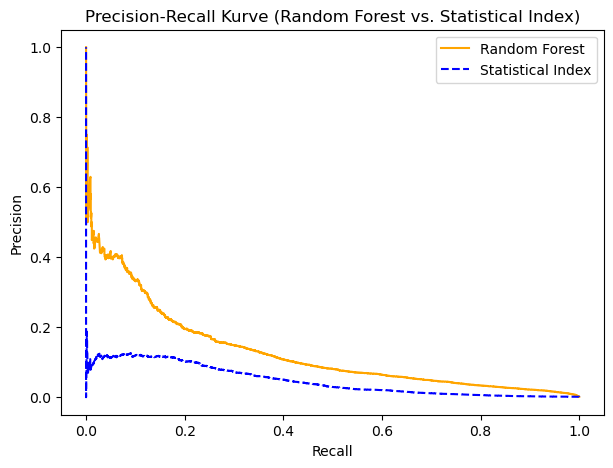

In [23]:
# calculate precision/recall curve
precision_rf, recall_rf, _ = precision_recall_curve(y_true_eval, y_pred_prob_rf_eval)
precision_si, recall_si, _ = precision_recall_curve(y_true_eval, y_pred_prob_si_eval)

# plot curves
plt.figure(figsize=(7, 5))
plt.plot(recall_rf, precision_rf, label="Random Forest", color="orange")
plt.plot(recall_si, precision_si, label="Statistical Index", linestyle="dashed", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Kurve (Random Forest vs. Statistical Index)")
plt.legend()
plt.show()
